In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates

import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib.colors import LogNorm

from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.ticker                         # here's where the formatter is
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch


from astropy.io import fits




In [2]:
# Assembly task
# https://github.com/lsst/ip_isr/blob/main/python/lsst/ip/isr/isrTask.py

from lsst.ip.isr.assembleCcdTask import (AssembleCcdConfig, AssembleCcdTask)
from lsst.ip.isr.isrTask import (IsrTask, IsrTaskConfig)

#https://github.com/lsst/ip_isr/blob/main/python/lsst/ip/isr/overscan.py
from lsst.ip.isr import  OverscanCorrectionTaskConfig, OverscanCorrectionTask

In [3]:
# LSST Display
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
! eups list -s

afw                   g7427b6cd24+07073039e0 	current w_2023_37 setup
alert_packet          g6041bd2d66 	current w_2023_37 setup
analysis_drp          g8a53795882+f055a86da1 	current w_2023_37 setup
analysis_tools        g1887775915+5d6842635b 	current w_2023_37 setup
ap_association        g5d6d4c19cc+3a1db5c87a 	current w_2023_37 setup
ap_pipe               g06c608b3b8+c098c7025d 	current w_2023_37 setup
ap_verify             gb4c42bc3d5+407639ef99 	current w_2023_37 setup
astro_metadata_translator g0978aabd1f+2a7d2c9fe3 	current w_2023_37 setup
astshim               g3273194fdb+f6908454ef 	current w_2023_37 setup
atmospec              LOCAL:/home/m/monroy/repos/repos_w_2023_35/atmospec 	setup
base                  g98ffbb4407+81bc2a20b4 	current w_2023_37 setup
cbp                   ga32fcf49c8+3004013d9a 	current w_2023_37 setup
coadd_utils           g337abbeb29+3004013d9a 	current w_2023_37 setup
cp_pipe               g857a3418e4+f055a86da1 	current w_2023_37 setup
cp_verify       

# Butler 

In [6]:
import lsst.daf.butler as dafButler

In [7]:
embargo = True

In [8]:
if embargo:
    repo="/sdf/group/rubin/repo/oga/"
else:
    repo = "/sdf/group/rubin/repo/main"
butler = dafButler.Butler(repo)
registry = butler.registry

In [9]:
cameraName = 'LATISS'
'''
calibCollections = ['LATISS/defaults','LATISS/raw/all']
for col in registry.queryCollections("*LATISS/calib*"):
    #print(col)
    calibCollections.append(col)
'''
calibCollections = ['LATISS/calib','LATISS/raw/all']

# Paths 

In [42]:
outdir_base0 = '../output_special_flats/'
if os.path.exists(outdir_base0)==False:
    os.mkdir(outdir_base0)
outdir_base = os.path.join(outdir_base0,'sky_hologram_flat/')
if os.path.exists(outdir_base)==False:
    os.mkdir(outdir_base)


We check the different dimension records existing for *physical_filter*: 

In [11]:
phys_filters = list(registry.queryDimensionRecords('physical_filter',where="instrument='LATISS'"))

Print physical_filters with hologram in place: 

In [12]:
for f_ in phys_filters:
    if 'holo' in f_.name:
        print(f_.name)

empty~holo4_003
blank_bk7_wg05~holo4_003
KPNO_1111_436nm~holo4_003
KPNO_373A_677nm~holo4_003
KPNO_406_828nm~holo4_003
unknown~holo4_003
BG40~holo4_003
quadnotch1~holo4_003
RG610~holo4_003
FELH0600~holo4_003
SDSSg~holo4_003
SDSSr~holo4_003
SDSSi~holo4_003
BG40_65mm_1~holo4_003
BG40_65mm_2~holo4_003
OG550_65mm_1~holo4_003
OG550_65mm_2~holo4_003
SDSSg_65mm~holo4_003
SDSSr_65mm~holo4_003
SDSSi_65mm~holo4_003
SDSSu_65mm~holo4_003
SDSSz_65mm~holo4_003
SDSSy_65mm~holo4_003
empty~holo4_001
blank_bk7_wg05~holo4_001
KPNO_1111_436nm~holo4_001
KPNO_373A_677nm~holo4_001
KPNO_406_828nm~holo4_001
unknown~holo4_001
BG40~holo4_001
BG40_65mm_1~holo4_001
BG40_65mm_2~holo4_001
quadnotch1~holo4_001
RG610~holo4_001
OG550_65mm_1~holo4_001
OG550_65mm_2~holo4_001
FELH0600~holo4_001
SDSSg~holo4_001
SDSSr~holo4_001
SDSSi~holo4_001
SDSSu_65mm~holo4_001
SDSSg_65mm~holo4_001
SDSSr_65mm~holo4_001
SDSSi_65mm~holo4_001
SDSSz_65mm~holo4_001
SDSSy_65mm~holo4_001
collimator~holo4_003
collimator~holo4_001
cyl_lens~holo4_0

In [13]:
obs_type = 'engtest'
obs_day = 20230921
target = 'slew_icrs' 
disperser = 'holo4_003'

In [14]:
df_science = pd.DataFrame(columns=['id', 'obs_id','day_obs', 'seq_num','exp_time','time_start',
                                    'time_end' ,'type', 'target','filter_disp','zenith_angle',
                                    'ra','dec','skyangle','science_program'])

In [15]:

#where_exps = "instrument='LATISS' AND exposure.observation_type='{0}' AND exposure.day_obs={1} AND exposure.target_name='{2}' AND physical_filter='{3}'".format(obs_type,obs_day,target,physical_filter)
where_exps = "instrument='LATISS' AND exposure.observation_type='{0}' AND exposure.day_obs={1} AND exposure.target_name='{2}'".format(obs_type,obs_day,target)
#where_exps = "instrument='LATISS' AND exposure.observation_type='{0}' AND exposure.day_obs={1}".format(obs_type,obs_day)
for i, info in enumerate(registry.queryDimensionRecords('exposure',where=where_exps)):
    
    #if info.observation_type=='science':
    id_ = info.id
    obs_id_ = info.obs_id
    day_obs_ = info.day_obs
    seq_num_ = info.seq_num
    timespan_ = info.timespan
    timespan_begin_ = pd.to_datetime(timespan_.begin.to_string())
    timespan_end_ = pd.to_datetime(timespan_.end.to_string())
    timespan_begin_jd_ = timespan_.begin.jd
    timespan_begin_mjd_ = timespan_.begin.mjd

    observation_type_ = info.observation_type
    target_name_ = info.target_name
    physical_filter_ = info.physical_filter
    zenith_angle_ = info.zenith_angle
    exposure_time_ = info.exposure_time
    tracking_ra_ = info.tracking_ra
    tracking_dec_ = info.tracking_dec
    sky_angle_ = info.sky_angle
    science_program_ = info.science_program
    
    if disperser in physical_filter_:
        df_science.loc[i] = [id_, obs_id_, day_obs_, seq_num_,exposure_time_,timespan_begin_,timespan_end_ ,observation_type_, \
                             target_name_, physical_filter_, zenith_angle_,tracking_ra_, \
                             tracking_dec_, sky_angle_, science_program_]

    if i < 2:
        print(i)
        print(info)
        print("\t timespan:            ",info.timespan)
        print("\t timespan.begin:      ",info.timespan.begin)
        print("\t id:                  ",info.id)
        print("\t day_obs:             ",info.day_obs)
        print("\t seq_num:             ",info.seq_num)
        print("\t type-of-observation: ",info.observation_type)
        print("\t target:              ",info.target_name)
        print("-----------------------------------------------------")
    

0
exposure:
  instrument: 'LATISS'
  id: 2023092100319
  physical_filter: 'SDSSg_65mm~pinhole_1_1000'
  obs_id: 'AT_O_20230921_000319'
  exposure_time: 30.0
  dark_time: 30.2282
  observation_type: 'engtest'
  observation_reason: 'engtest'
  day_obs: 20230921
  seq_num: 319
  seq_start: 319
  seq_end: 319
  group_name: '2023-09-21T22:47:34.136'
  group_id: 2752660541360000
  target_name: 'slew_icrs'
  science_program: 'unknown'
  tracking_ra: 282.5075523925613
  tracking_dec: -29.764322742184238
  sky_angle: 184.21772338204977
  azimuth: 89.90480604252305
  zenith_angle: 9.836382143305684
  has_simulated: False
  timespan: Timespan(begin=astropy.time.Time('2023-09-21 22:47:34.572996', scale='tai', format='iso'), end=astropy.time.Time('2023-09-21 22:48:04.802000', scale='tai', format='iso'))
	 timespan:             [2023-09-21T22:47:34.572996, 2023-09-21T22:48:04.802000)
	 timespan.begin:       2023-09-21 22:47:34.572996
	 id:                   2023092100319
	 day_obs:              2023

In [16]:
print('Number of entries = ',len(df_science))

Number of entries =  9


In [17]:
df_science

,id,obs_id,day_obs,seq_num,exp_time,time_start,time_end,type,target,filter_disp,zenith_angle,ra,dec,skyangle,science_program
5,2023092100334,AT_O_20230921_000334,20230921,334,10.0,2023-09-21 23:01:53.630015,2023-09-21 23:02:03.875,engtest,slew_icrs,empty~holo4_003,6.784910,282.558635,-29.732597,184.217522,unknown
7,2023092100340,AT_O_20230921_000340,20230921,340,10.0,2023-09-21 23:03:58.844986,2023-09-21 23:04:09.086,engtest,slew_icrs,SDSSg_65mm~holo4_003,6.327001,282.548138,-29.717994,184.217780,unknown
9,2023092100346,AT_O_20230921_000346,20230921,346,10.0,2023-09-21 23:06:07.542015,2023-09-21 23:06:17.782,engtest,slew_icrs,SDSSr_65mm~holo4_003,5.845558,282.527162,-29.707249,184.217599,unknown
20,2023092100335,AT_O_20230921_000335,20230921,335,10.0,2023-09-21 23:02:14.019001,2023-09-21 23:02:24.252,engtest,slew_icrs,empty~holo4_003,6.738438,282.586689,-29.719917,184.217822,unknown
21,2023092100336,AT_O_20230921_000336,20230921,336,10.0,2023-09-21 23:02:35.987982,2023-09-21 23:02:46.226,engtest,slew_icrs,empty~holo4_003,6.660002,282.589372,-29.732876,184.217477,unknown
23,2023092100341,AT_O_20230921_000341,20230921,341,10.0,2023-09-21 23:04:21.424989,2023-09-21 23:04:31.652,engtest,slew_icrs,SDSSg_65mm~holo4_003,6.237732,282.537346,-29.723976,184.217892,unknown
25,2023092100347,AT_O_20230921_000347,20230921,347,10.0,2023-09-21 23:06:27.280995,2023-09-21 23:06:37.522,engtest,slew_icrs,SDSSr_65mm~holo4_003,5.757409,282.501107,-29.685671,184.217612,unknown
37,2023092100342,AT_O_20230921_000342,20230921,342,10.0,2023-09-21 23:04:41.026009,2023-09-21 23:04:51.259,engtest,slew_icrs,SDSSg_65mm~holo4_003,6.152750,282.519533,-29.703434,184.217608,unknown
39,2023092100348,AT_O_20230921_000348,20230921,348,10.0,2023-09-21 23:06:47.725020,2023-09-21 23:06:57.958,engtest,slew_icrs,SDSSr_65mm~holo4_003,5.689982,282.508400,-29.671270,184.217648,unknown


### Available filters 

In [18]:
np.unique(np.array(df_science.filter_disp))

array(['SDSSg_65mm~holo4_003', 'SDSSr_65mm~holo4_003', 'empty~holo4_003'],
      dtype=object)

### Select a filter 

In [19]:
filter = 'SDSSr_65mm'
physical_filter = '{0}~{1}'.format(filter,disperser)

In [20]:
df_selected = df_science[df_science.filter_disp==physical_filter]

In [21]:
seq_nums = np.sort(np.array(df_selected.seq_num))
print(seq_nums)

[346 347 348]


In [22]:
ids = np.sort(np.array(df_selected.id))
print(ids)

[2023092100346 2023092100347 2023092100348]


We test retrieving one of them: 

In [23]:
seq_num0 = seq_nums[0]
exp_id0 = ids[0]
print(exp_id0)

2023092100346


In [24]:
test_img = butler.get('raw', dataId={'exposure': exp_id0, 'instrument': 'LATISS', 'detector': 0}, collections = calibCollections)

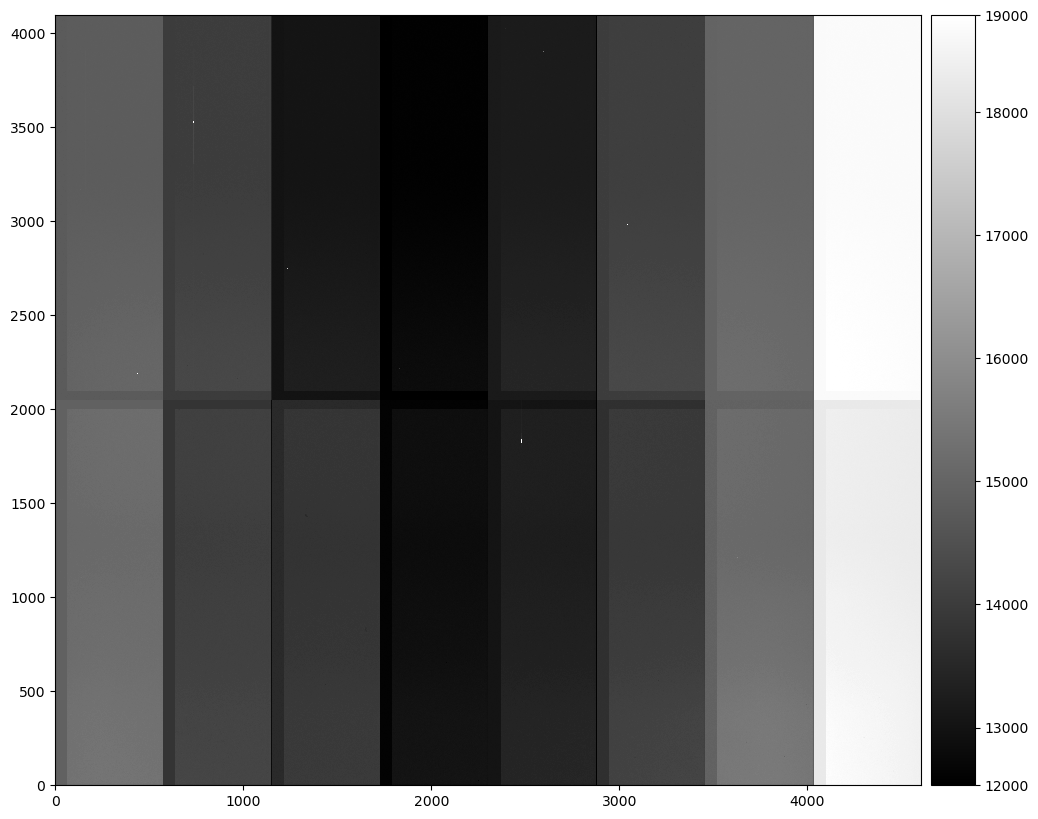

In [25]:
fig = plt.figure(figsize=(12,10))
afw_display = afwDisplay.Display(frame=fig)
afw_display.scale('linear', 'zscale',None)
afw_display.mtv(test_img.image)

## Organize amplifiers 

In [26]:
ampli_boxes = {}
ampli_names = []
for ampIdx, amp in enumerate(test_img.getDetector()):
    ampli_name_ = amp.getName()
    ampli_names.append(ampli_name_)
    xbegin = amp.getBBox().x.begin
    xend = amp.getBBox().x.end
    ybegin = amp.getBBox().y.begin
    yend = amp.getBBox().y.end
    ampli_boxes[ampli_name_] = (xbegin,xend,ybegin,yend)

In [27]:
ampli_boxes

{'C10': (0, 509, 2000, 4000),
 'C11': (509, 1018, 2000, 4000),
 'C12': (1018, 1527, 2000, 4000),
 'C13': (1527, 2036, 2000, 4000),
 'C14': (2036, 2545, 2000, 4000),
 'C15': (2545, 3054, 2000, 4000),
 'C16': (3054, 3563, 2000, 4000),
 'C17': (3563, 4072, 2000, 4000),
 'C07': (3563, 4072, 0, 2000),
 'C06': (3054, 3563, 0, 2000),
 'C05': (2545, 3054, 0, 2000),
 'C04': (2036, 2545, 0, 2000),
 'C03': (1527, 2036, 0, 2000),
 'C02': (1018, 1527, 0, 2000),
 'C01': (509, 1018, 0, 2000),
 'C00': (0, 509, 0, 2000)}

We do the ISR on this image the same way we do it with the spectra images (i.e., we do our pseudo-postISRCCD): 

In [28]:
# configuration
isr_config =  IsrTaskConfig()

In [29]:
isr_config.doDark = False
isr_config.doFlat =  False
isr_config.doFringe = False
isr_config.doDefect = True
isr_config.doLinearize = False
isr_config.doCrosstalk =  False
isr_config.doSaturationInterpolation = False
isr_config.overscan.fitType: 'MEDIAN_PER_ROW'
isr_config.doBias: True


In [30]:
isr_task = IsrTask(config=isr_config)

In [31]:
butler = dafButler.Butler(repo, collections=calibCollections)
camera = butler.get('camera', instrument=cameraName)
#bias = butler.get('bias',instrument=cameraName,detector=0)
#defects = butler.get('defects',instrument=cameraName,detector=0)

In [32]:

bias = butler.get("bias",instrument=cameraName, exposure= exp_id0, detector=0, collections=calibCollections)
defects = butler.get('defects',instrument=cameraName, exposure= exp_id0,detector=0,collections=calibCollections)

#fast ISR 
isr_test = isr_task.run(test_img,bias=bias,defects=defects)


In [33]:
test_ = isr_test.exposure.image.array

Value range 

In [34]:
np.min(test_.flatten())

-94.03019

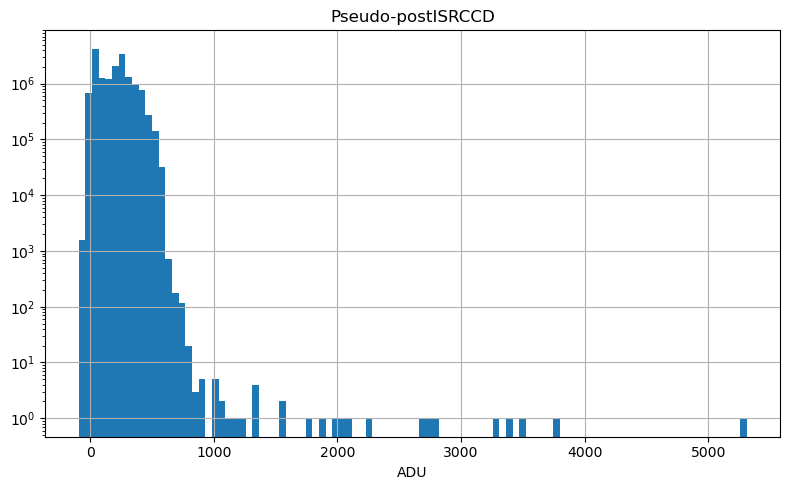

In [35]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
_ = ax.hist(test_.flatten(),bins=100)
ax.set_yscale("log")
ax.grid()
ax.set_xlabel('ADU')
ax.set_title('Pseudo-postISRCCD')
plt.tight_layout()

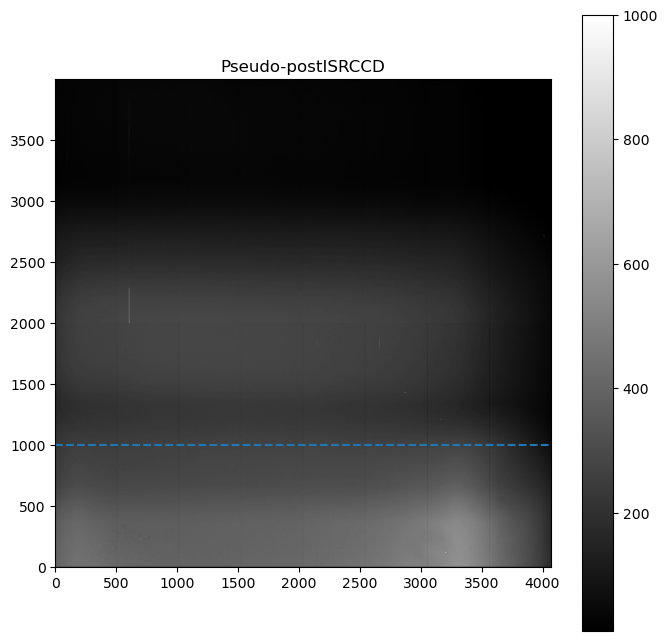

In [40]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
#im = ax.imshow(isr_test.exposure.image.array,cmap="gray",origin='lower',norm=LogNorm())
im = ax.imshow(test_,cmap="gray",origin='lower',vmin=10,vmax=1000)
ax.axhline(y=1000,ls='--')
ax.set_title('Pseudo-postISRCCD')
fig.colorbar(im,ax=ax)

# Do ISR for all available flats and save in fits file 

In [37]:
save_flats = True

In [43]:
if save_flats:
    outdir_ = '{0}/'.format(obs_day)
    outdir = os.path.join(outdir_base,outdir_)
    if os.path.exists(outdir)==False:
        os.mkdir(outdir)

In [39]:
exp_list = []
ampli_boxes = {}
ampli_names = []
for i,exp_id_ in enumerate(ids):
    print(exp_id_)
    raw_img_ = butler.get('raw', dataId={'exposure': exp_id_, 'instrument': 'LATISS', 'detector': 0}, collections = calibCollections)
    print('Raw image retrieved')
    
    bias_ = butler.get("bias",instrument=cameraName, exposure= exp_id_, detector=0, collections=calibCollections)
    defects_ = butler.get('defects',instrument=cameraName, exposure= exp_id_,detector=0,collections=calibCollections)
    
    #fast ISR 
    print('Running pseudo-ISR')
    isr_img_ = isr_task.run(raw_img_,bias=bias_,defects=defects_)
    
    exp_list.append(isr_img_)
    print('-----------------')
    
    if save_flats:
        md_ = raw_img_.getMetadata().toDict()
        
        filename_out_ = 'holo_sky_flat_{0}_{1}.fits'.format(exp_id_,physical_filter.replace('~','-'))
        fullfilename_out_ = os.path.join(outdir,filename_out_)

        print(f">>>>  output filename {filename_out_}")

        hdr_ = fits.Header()

        for key,value in md_.items():
            hdr_[str(key)] = value

        # Be carefull for Spectractor, 2 hdu units are necessary

        primary_hdu = fits.PrimaryHDU(header=hdr_)
        image_hdu = fits.ImageHDU(isr_img_.exposure.image.array)

        hdu_list = fits.HDUList([primary_hdu, image_hdu])

        hdu_list.writeto(fullfilename_out_,overwrite=True)


2023092100346
Raw image retrieved
Running pseudo-ISR


-----------------
>>>>  output filename holo_sky_flat_2023092100346_SDSSr_65mm-holo4_003.fits
2023092100347
Raw image retrieved
Running pseudo-ISR


-----------------
>>>>  output filename holo_sky_flat_2023092100347_SDSSr_65mm-holo4_003.fits
2023092100348
Raw image retrieved
Running pseudo-ISR


-----------------
>>>>  output filename holo_sky_flat_2023092100348_SDSSr_65mm-holo4_003.fits
